# Inspect the Point-Source Visibility Simulations

In [1]:
from pyradiosky import SkyModel
from pyuvdata.uvdata import FastUVH5Meta
import numpy as np
from pathlib import Path
import h5py
import sys
import matplotlib.pyplot as plt
from scipy.signal.windows import blackmanharris
from uvtools import plot

In [2]:
sys.path.append("..")

In [3]:
from core import utils

In [4]:
pth = utils.OUTDIR / "ptsrc1024" / "nt17280-00001chunks-FULL-red"

In [57]:
ptsrc_files = sorted(pth.glob("*.uvh5"))

In [58]:
len(ptsrc_files)

782

In [8]:
freq_chunks = [(0, 150), (500, 650)]

In [9]:
meta = FastUVH5Meta(ptsrc_files[0])

In [75]:
meta.antpos_enu[11] - meta.antpos_enu[0]

array([-7.35223164, 12.62289218, -0.12132382])

In [ ]:
# Add some longer baselines, EW and NS

In [10]:
antpairs = [
    (0, 1),
    (0, 2),
    (0, 4),
    (0, 11),
    (0, 23),
    (0, 52)
]

In [11]:
blidx = [meta.antpairs.index(p) if p in meta.antpairs else meta.antpairs.index(p[::-1]) for p in antpairs]

In [12]:
polidx = [meta.pols.index('xx'), meta.pols.index('yy')]

In [13]:
pols = ['xx', 'yy']

In [14]:
meta.Ntimes * meta.Nbls * 2 * 16 / 1024**3

3.404560089111328

In [64]:
all_data = [np.zeros((meta.Ntimes, len(antpairs), 150, 2), dtype=complex) for _ in freq_chunks]
freqs = [np.zeros(150) for _ in freq_chunks]

chsize = meta.Nbls*meta.Ntimes//4
_ch = meta.Ntimes//4

for ipol, pol in enumerate(polidx):
    print("pol", ipol)
    for ichunk, fchunk in enumerate(freq_chunks):
        print(f"Chunk {ichunk+1}")
        for ffidx, fidx in enumerate(range(fchunk[0], fchunk[1])):
            fl = pth / f"fch{fidx:>04}_chunk00000.uvh5"

            if not fl.exists():
                print(f"Got to {fidx}")
                break
            
            for tchunk in range(4):
                with h5py.File(fl,'r') as _fl:
                    d = _fl['Data']['visdata'][tchunk*chsize:(tchunk+1)*chsize, 0, pol].reshape((meta.Ntimes//4, meta.Nbls))
                    freqs[ichunk][ffidx] = _fl['Header']['freq_array'][0]
                    all_data[ichunk][tchunk*_ch:(tchunk+1)*_ch, :, ffidx, ipol] = d[:, blidx]
                del d
        

pol 0
Chunk 1
Chunk 2
pol 1
Chunk 1
Chunk 2


In [30]:
all_data[0].shape

(4320, 6, 150, 1)

## WaterFalls

In [85]:
def plot_multibl_waterfall(freqs, all_data, pols=(0, 1)):
    fig, ax = plt.subplots(len(pols)*2, len(blidx), constrained_layout=True, figsize=(12, len(pols)*2*3), sharex=True, sharey=True, gridspec_kw={"hspace": 0, 'wspace': 0})

    extent = (freqs[0]/1e6, freqs[-1]/1e6, meta.lsts[0]*12/np.pi, meta.lsts[meta.Ntimes-1]*12/np.pi)
    amp_clim = (np.min(np.abs(all_data)), np.max(np.abs(all_data)))
    for j, bl in enumerate(antpairs):
        ax[0, j].set_title(bl)
        for ipol, pol in enumerate(pols):
            phs_img = ax[ipol,j].imshow(np.angle(all_data[:, j, :, pol]), cmap='twilight', aspect='auto', extent=extent, clim=(-np.pi, np.pi))
            amp_img = ax[ipol+len(pols), j].imshow(np.abs(all_data[:, j, :, pol]), cmap='magma', aspect='auto', extent=extent, clim=amp_clim)

    for i in range(len(pols)*2):
        ax[i,0].set_ylabel("LST [hr]")

    fig.colorbar(phs_img, ax=ax[:len(pols)])
    fig.colorbar(amp_img, ax=ax[len(pols):])

    # ax[0, -1].text(1, 0.9,"xx phase",  transform=ax[0, -1].transAxes )
    # ax[1, -1].text(1, 0.9,"yy phase", transform=ax[1, -1].transAxes)
    # ax[2, -1].text(1, 0.9,"xx amp",transform=ax[2, -1].transAxes)
    # ax[3, -1].text(1, 0.9,"yy amp",transform=ax[3, -1].transAxes)


Text(0.5, 0.98, 'xx pol')

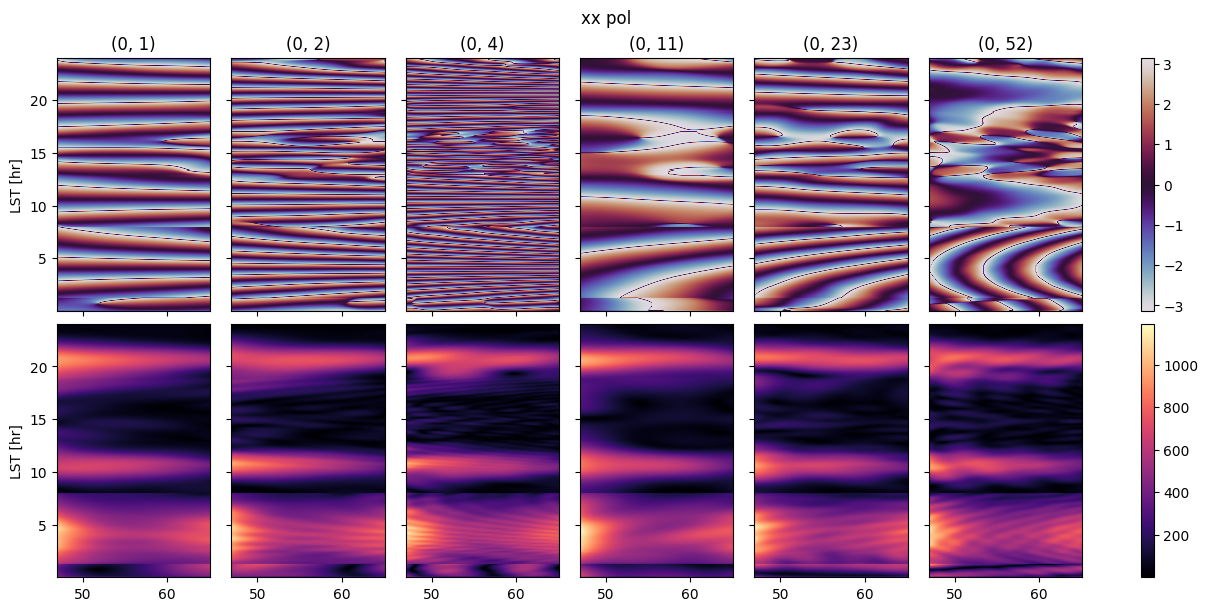

In [83]:
plot_multibl_waterfall(freqs[0], all_data[0], pols=(0,))
plt.suptitle("xx pol")

Text(0.5, 0.98, 'yy pol')

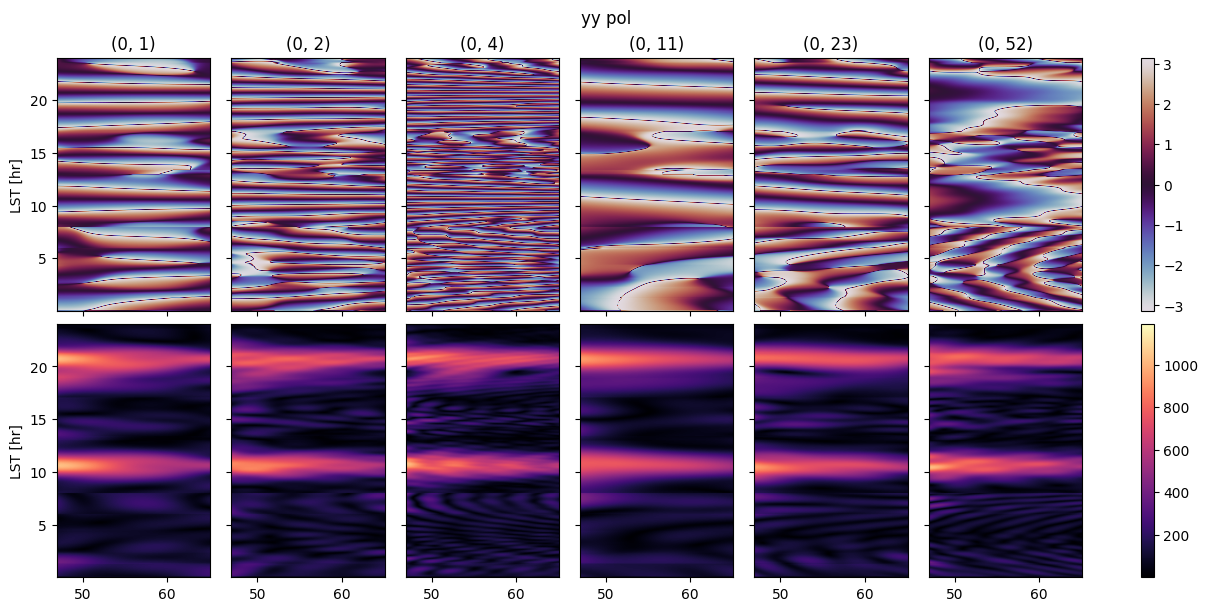

In [86]:
plot_multibl_waterfall(freqs[0], all_data[0], pols=(1,))
plt.suptitle("yy pol")

Text(0.5, 0.98, 'xx')

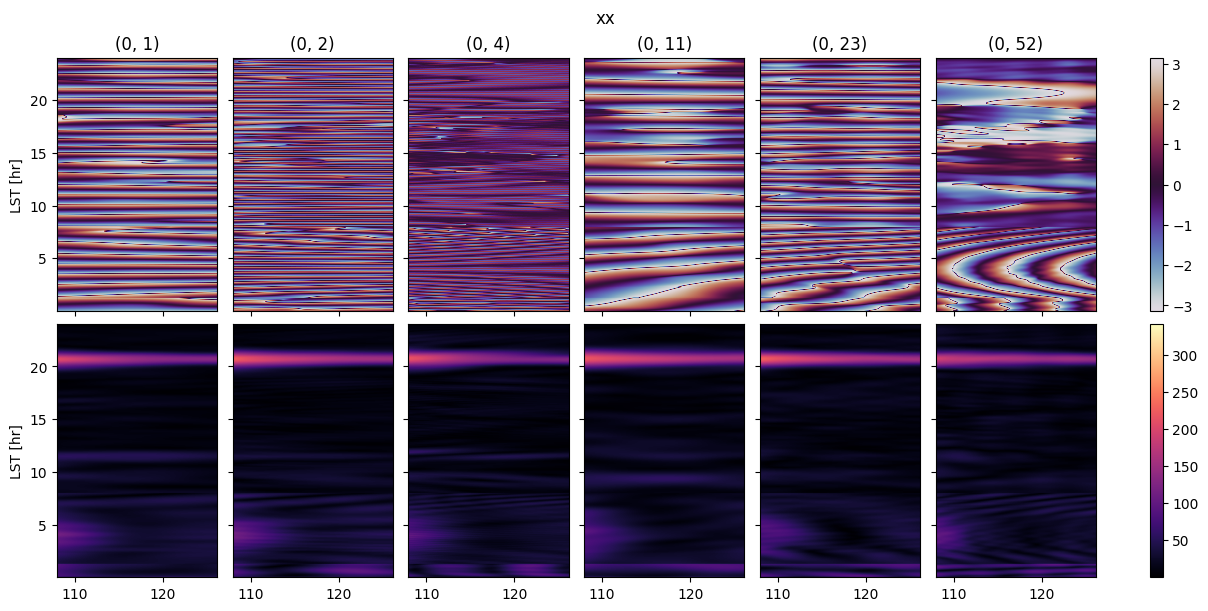

In [88]:
plot_multibl_waterfall(freqs[1], all_data[1], pols=(0,))
plt.suptitle("xx")

Text(0.5, 0.98, 'yy')

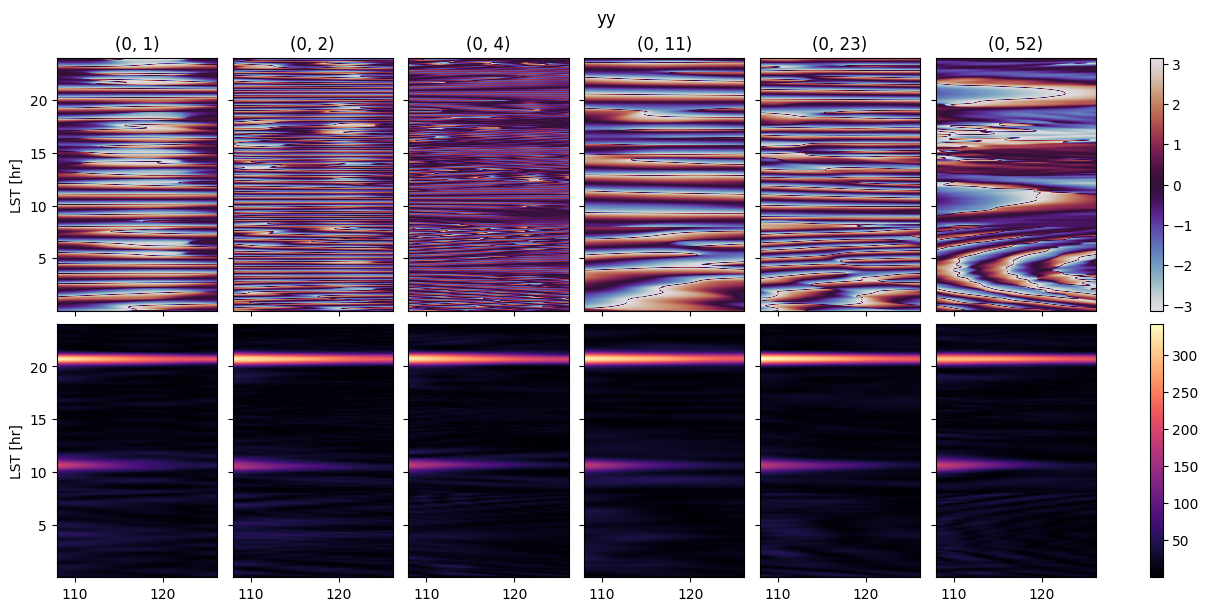

In [89]:
plot_multibl_waterfall(freqs[1], all_data[1], pols=(1,))
plt.suptitle("yy")

## Frequency-Based Inspection


In [43]:
def get_delayspec(freqs: np.ndarray, data: np.ndarray):
    power = np.abs(np.fft.fftshift(np.fft.fft(data*blackmanharris(data.shape[-2])[None, None, :, None]**2, axis=-2)))**2
    delays = np.fft.fftshift(np.fft.fftfreq(data.shape[-2], d=freqs[1] - freqs[0]))
    return power, delays*1e9

Text(0, 0.5, 'Mid Band')

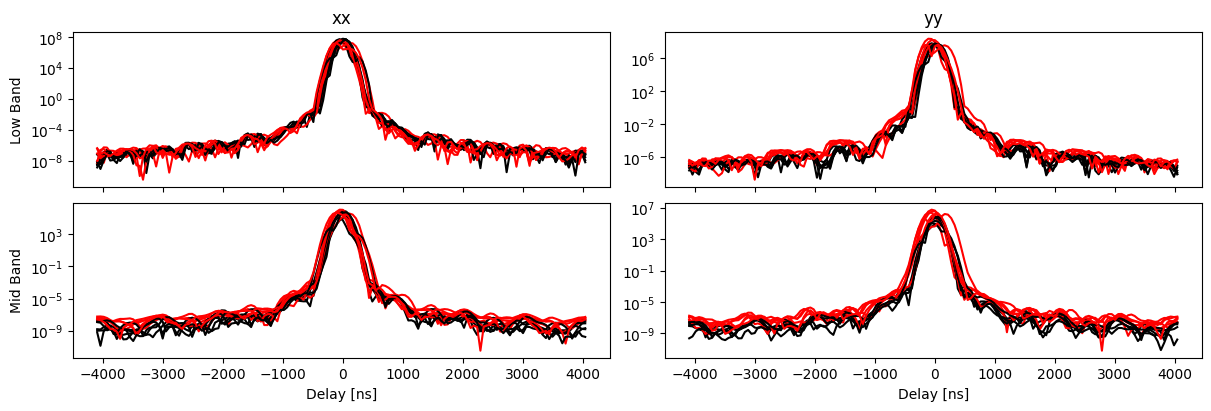

In [94]:
fig, ax = plt.subplots(2, 2, sharex=True, constrained_layout=True, figsize=(12, 4))

power0, tau0 = get_delayspec(freqs[0], all_data[0])
power1, tau1 = get_delayspec(freqs[1], all_data[1])

for i, p in enumerate(antpairs):
    for pol in (0, 1):
        #pk, tau = get_delayspec(freqs[0], all_data[0][:, i, :, pol])
        ax[0, pol].plot(tau0, power0[0, i, :, pol], color='k')
        ax[0, pol].plot(tau0, power0[8000, i, :, pol], color='r')

        ax[1, pol].plot(tau1, power1[0, i, :, pol], color='k')
        ax[1, pol].plot(tau1, power1[8000, i, :, pol], color='r')
        
    #ax.set_ylabel(str(p))
ax[0,0].set_yscale('log')
ax[1,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')


ax[1,0].set_xlabel("Delay [ns]")
ax[1,1].set_xlabel("Delay [ns]")
ax[0,0].set_title("xx")
ax[0,0].set_ylabel("Low Band")

ax[0,1].set_title("yy")
ax[1,0].set_ylabel("Mid Band")

## Time-Based Inspection

In [51]:
def get_frspec(freqs: np.ndarray, data: np.ndarray):
    power = np.abs(np.fft.fftshift(np.fft.fft(data*blackmanharris(data.shape[0])[:, None, None, None]**2, axis=0)))**2
    delays = np.fft.fftshift(np.fft.fftfreq(data.shape[0], d=meta.integration_time[0]))
    return power, delays

In [98]:
frspec0, frs0 = get_frspec(freqs[0], all_data[0])
frspec1, frs1 = get_frspec(freqs[1], all_data[1])


Text(0, 0.5, 'Mid Band')

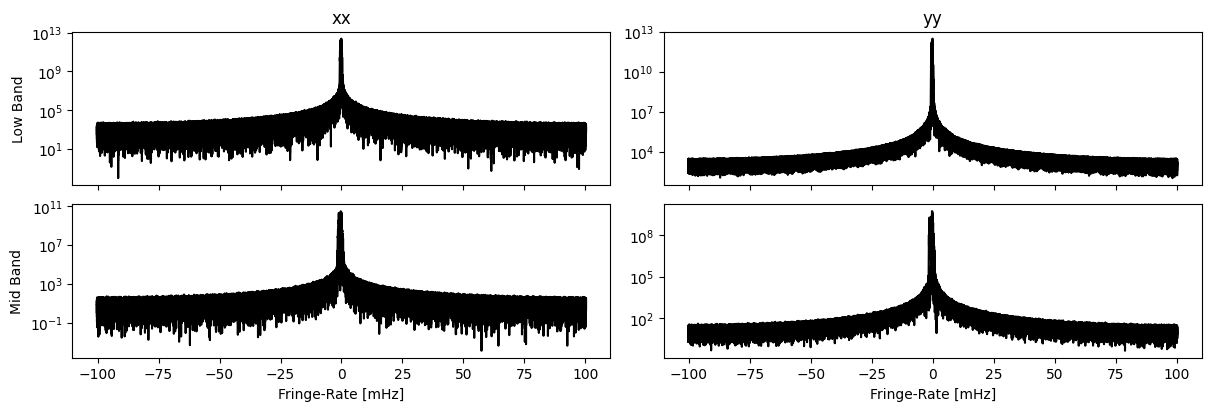

In [99]:
fig, ax = plt.subplots(2, 2, sharex=True, constrained_layout=True, figsize=(12, 4))

for i, p in enumerate(antpairs):
    for pol in (0, 1):
        #pk, tau = get_delayspec(freqs[0], all_data[0][:, i, :, pol])
        ax[0, pol].plot(frs0*1e3, frspec0[:, i, 75, pol], color='k')
        
        ax[1, pol].plot(frs1*1e3, frspec1[:, i, 75, pol], color='k')
        
    #ax.set_ylabel(str(p))
ax[0,0].set_yscale('log')
ax[1,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')


ax[1,0].set_xlabel("Fringe-Rate [mHz]")
ax[1,1].set_xlabel("Fringe-Rate [mHz]")
ax[0,0].set_title("xx")
ax[0,0].set_ylabel("Low Band")

ax[0,1].set_title("yy")
ax[1,0].set_ylabel("Mid Band")


# fig, ax = plt.subplots(2,2, sharex=True, sharey=True, 
# for i, p in enumerate(antpairs):
#     for pol in (0, ):
#         plt.plot(frs*1e3, frspec[:, i, 0,pol], color='k')
#         plt.plot(frs*1e3, frspec[:, i, 100,pol], color='r')
# plt.yscale('log')
# plt.xlim(-10,10)

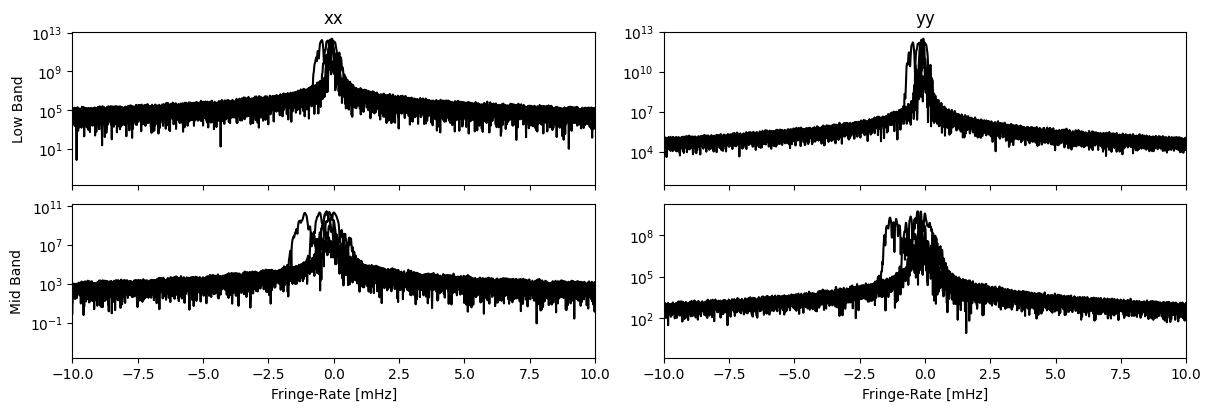

In [100]:
fig, ax = plt.subplots(2, 2, sharex=True, constrained_layout=True, figsize=(12, 4))

for i, p in enumerate(antpairs):
    for pol in (0, 1):
        #pk, tau = get_delayspec(freqs[0], all_data[0][:, i, :, pol])
        ax[0, pol].plot(frs0*1e3, frspec0[:, i, 75, pol], color='k')
        
        ax[1, pol].plot(frs1*1e3, frspec1[:, i, 75, pol], color='k')
        
    #ax.set_ylabel(str(p))
ax[0,0].set_yscale('log')
ax[1,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,1].set_yscale('log')


ax[1,0].set_xlabel("Fringe-Rate [mHz]")
ax[1,1].set_xlabel("Fringe-Rate [mHz]")
ax[0,0].set_title("xx")
ax[0,0].set_ylabel("Low Band")

ax[0,1].set_title("yy")
ax[1,0].set_ylabel("Mid Band")

for axx in ax.flatten():
    axx.set_xlim(-10,10)